In [ ]:
#@title Imports + Default Settings.
import numpy as np
import matplotlib.pyplot as plt

# Configure matplotlib sizes
small = 15
medium = 18
large = 20
plt.rc('axes', titlesize=large)
plt.rc('axes', labelsize=medium)
plt.rc('xtick', labelsize=small)
plt.rc('ytick', labelsize=small)
plt.rc('legend',fontsize=small)
plt.rc('figure',titlesize=large)

Define a class for the environment

In [ ]:
class EnvironmentFlipsTask:
  # An environment for a two-armed bandit RL task, with reward probabilities that flip in blocks

  def __init__(
      self,
      block_flip_prob,
      reward_prob_high,
      reward_prob_low,
  ):
    # Assign the input parameters as properties
    self._block_flip_prob = block_flip_prob
    self._reward_prob_high = reward_prob_high
    self._reward_prob_low = reward_prob_low
    # Choose a random block to start in
    self._block = np.random.binomial(1, 0.5)
    # Set up the new block
    self.new_block()

  def new_block(self):
    # Flip the block
    self._block = 1 - self._block
    # Set the reward probabilites
    if self._block == 1:
      self.reward_probabilities = [self._reward_prob_high,
                                   self._reward_prob_low]
    else:
      self.reward_probabilities = [self._reward_prob_low,
                                   self._reward_prob_high]

  def next_trial(self, choice):
    # Choose the reward probability associated with the choice that the agent made
    reward_prob_trial = self.reward_probabilities[choice]

    # Sample a reward with this probability
    reward = np.random.binomial(1, reward_prob_trial)

    # Check whether to flip the block
    if np.random.binomial(1, self._block_flip_prob):
      self.new_block()

    # Return the reward
    return reward


In [ ]:
my_task = EnvironmentFlipsTask(block_flip_prob=0.05, reward_prob_high = 0.8, reward_prob_low = 0.4)

print(my_task.reward_probabilities)

my_task.new_block()

print(my_task.reward_probabilities)

[0.8, 0.4]
[0.4, 0.8]


Define a class for the agent

In [ ]:
class AgentVanillaQ:
  # An agent implementing textbook Q-learning, using a softmax policy

  def __init__(
      self,
      learning_rate,
      decision_weight
  ):
    self._learning_rate = learning_rate
    self._decision_weight = decision_weight
    # Initialize q-values to 50%
    self.q = 0.5 * np.ones(2)

  def softmax(self, x):
    softmax_x = np.exp(x) / np.sum(np.exp(x))
    return softmax_x

  def get_choice(self):
    # Draw choice probabilities according to the softmax
    choice_probs = self.softmax(self._decision_weight * self.q)
    # Select a choice according to the probabilities
    choice = np.random.binomial(1, choice_probs[1])
    return choice

  def update_qs(self,
                choice,
                reward):
    # Update the q-value of the chosen side towards the reward
    self.q[choice] = self.q[choice] * (1 - self._learning_rate) + self._learning_rate * reward


Instantiate an environment and an agent

In [ ]:
# Environment Parameters
block_flip_prob = 0.01
reward_prob_high = 0.8
reward_prob_low = 0.2

# Agent Parameters
learning_rate = 0.1
decision_weight = 3


# Instantiate environment with these parameters
environment = EnvironmentFlipsTask(block_flip_prob = block_flip_prob,
                            reward_prob_high = reward_prob_high,
                            reward_prob_low = reward_prob_low)
# Instantiate agent with these parameters
agent = AgentVanillaQ(learning_rate,
                      decision_weight)


Generate a synthetic dataset

In [ ]:
# Experiment Parameters
n_trials = 500

# Empty variables to accumulate choices, rewards, block, qs
choices = np.zeros(n_trials)
rewards = np.zeros(n_trials)
reward_probabilities = np.zeros((n_trials,2))
qs = np.zeros((n_trials,2))

for t in range(n_trials):
  # Ask the agent for a choice
  choice = agent.get_choice()
  # Step the environment, get a reward
  reward = environment.next_trial(choice)
  # Let the agent know about the reward
  agent.update_qs(choice, reward)

  # Record the choice, reward
  choices[t] = choice
  rewards[t] = reward
  reward_probabilities[t] = environment.reward_probabilities
  qs[t] = agent.q

Characterize the synthetic dataset

Agent Reward Rate: 0.596


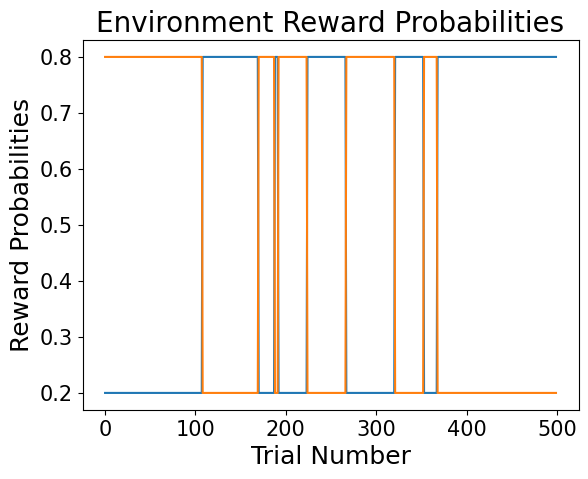

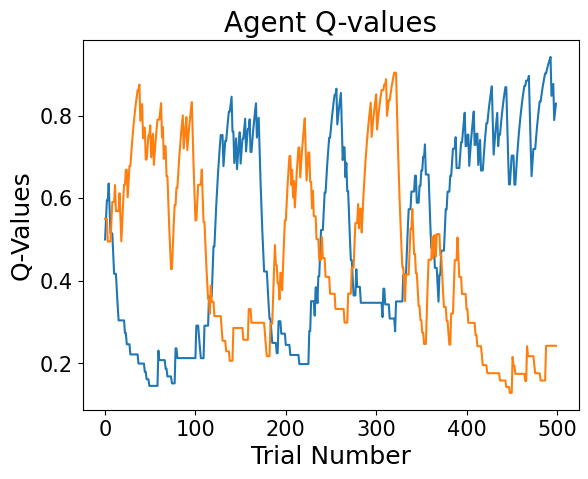

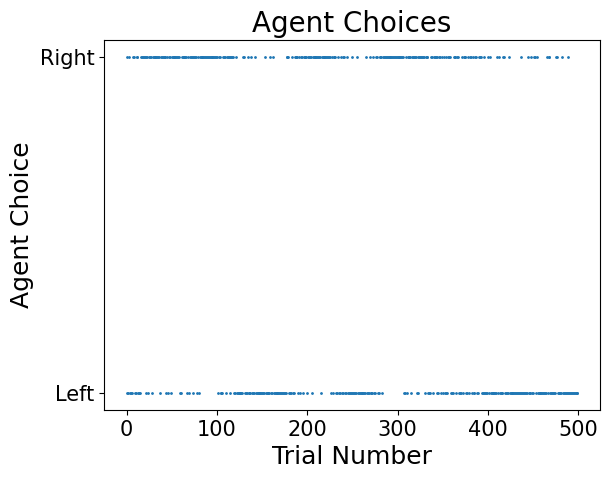

In [ ]:
# Environment Reward Probabilities
plt.figure()
plt.plot(reward_probabilities)
plt.xlabel('Trial Number')
plt.ylabel('Reward Probabilities')
plt.title('Environment Reward Probabilities')

# Agent Q-Values
plt.figure()
plt.plot(qs)
plt.xlabel('Trial Number')
plt.ylabel('Q-Values')
plt.title('Agent Q-values')

# Agent Choices
plt.figure()
plt.scatter(np.arange(n_trials),
            choices,
            1)
plt.xlabel('Trial Number')
plt.ylabel('Agent Choice')
plt.title('Agent Choices')
plt.yticks((0,1), labels=('Left', 'Right'))

# Total reward rate
print('Agent Reward Rate:', np.mean(rewards))
